In [0]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, utils
from torch.autograd import Variable

def show_as_image(binary_image, figsize=(10, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(binary_image, cmap='gray')
    plt.xticks([]); plt.yticks([])

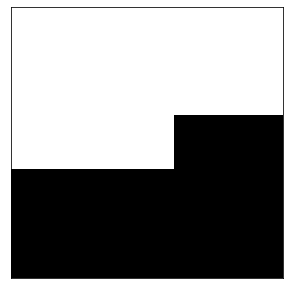

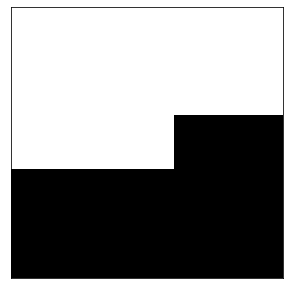

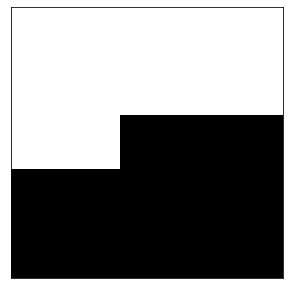

In [25]:
def causal_mask(width, height, starting_point):
    row_grid, col_grid = np.meshgrid(np.arange(width), np.arange(height), indexing='ij')
    mask = np.logical_and(row_grid == starting_point[0], col_grid <= starting_point[1])
    mask = np.logical_or( row_grid < starting_point[0], np.logical_and(row_grid == starting_point[0], col_grid <= starting_point[1]))
    return mask

def test(width, height, include_center):
    mask = np.ones((width,height))
    mask[width//2, height//2+include_center:] = 0
    mask[width//2+1:] = 0
    return 1.0*mask

def conv_mask(width, height, include_center=False):
    return 1.0 * causal_mask(width, height, starting_point=(width//2, height//2 + include_center - 1))

show_as_image(test(5,5,include_center=True))
show_as_image(conv_mask(5, 5, include_center=True))
show_as_image(conv_mask(5, 5, include_center=False))

In [76]:
out_channels, in_channels, width, height = 2, 2, 3, 3
conv_weights = 1 + np.arange(out_channels * in_channels * width * height).reshape((out_channels, in_channels, width, height))
masked_weights = conv_weights * conv_mask(width, height)
masked_weights

array([[[[ 1.,  2.,  3.],
         [ 4.,  0.,  0.],
         [ 0.,  0.,  0.]],

        [[10., 11., 12.],
         [13.,  0.,  0.],
         [ 0.,  0.,  0.]]],


       [[[19., 20., 21.],
         [22.,  0.,  0.],
         [ 0.,  0.,  0.]],

        [[28., 29., 30.],
         [31.,  0.,  0.],
         [ 0.,  0.,  0.]]]])

In [0]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        _, n_channels, width, height = self.weight.size()
        mask = conv_mask(width, height, include_center=mask_type=='B')
        self.register_buffer('mask', torch.from_numpy(mask).float())

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)


class PixelCNN(nn.Module):
    n_channels = 16
    kernel_size = 7
    padding = 3
    n_pixels_out = 2 # binary 0/1 pixels
    
    def __init__(self, in_channels=1):
        super(PixelCNN, self).__init__()
        self.layers = nn.Sequential(
            MaskedConv2d('A', in_channels=in_channels, out_channels=self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            MaskedConv2d('B', self.n_channels, self.n_channels, kernel_size=self.kernel_size, padding=self.padding, bias=False), nn.BatchNorm2d(self.n_channels), nn.ReLU(True),
            nn.Conv2d(in_channels=self.n_channels, out_channels=self.n_pixels_out, kernel_size=1)
        )
        
    def forward(self, x):
        pixel_logits = self.layers(x)
        return pixel_logits

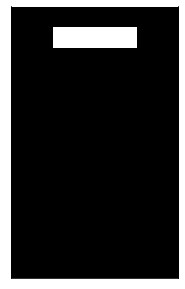

In [234]:
CELL_LENGTH = 4
IMAGE_WIDTH, IMAGE_HEIGHT = 2 * CELL_LENGTH + 5, CELL_LENGTH + 4

def vertical_stroke(rightness, downness):
    """
    Return a 2d numpy array representing an image with a single vertical stroke in it.
    `rightness` and `downness` are values from [0, 1] and define the position of the vertical stroke.
    """
    i = (downness * (CELL_LENGTH + 1)) + 2
    j = rightness * (CELL_LENGTH + 1) + 1
    x = np.zeros(shape=(IMAGE_WIDTH, IMAGE_HEIGHT), dtype=np.float64)
    x[i + np.arange(CELL_LENGTH), j] = 1.
    return x

def horizontal_stroke(downness):
    """
    Analogue to vertical_stroke, but it returns horizontal strokes.
    `downness` is here a value in [0, 1, 2].
    """
    i = (downness * (CELL_LENGTH + 1)) + 1
    x = np.zeros(shape=(IMAGE_WIDTH, IMAGE_HEIGHT), dtype=np.float64)
    x[i, 2 + np.arange(CELL_LENGTH)] = 1.
    return x

show_as_image(horizontal_stroke(0))

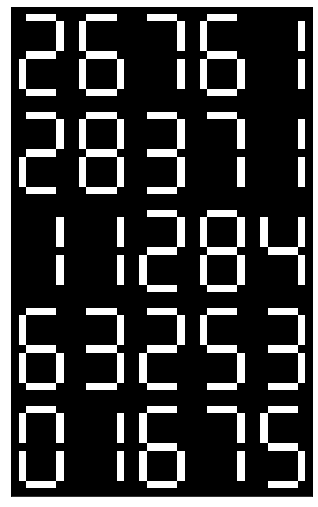

In [235]:
BASE_STROKES = np.asarray( [horizontal_stroke(k) for k in range(3)] + [vertical_stroke(k, l) for k in range(2) for l in range(2)])

DIGITS_STROKES = np.array([[0, 2, 3, 4, 5, 6], [5, 6], [0, 1, 2, 4, 5], [0, 1, 2, 5, 6], [1, 3, 5, 6], [0, 1, 2, 3, 6], [0, 1, 2, 3, 4, 6], [0, 5, 6], np.arange(7), [0, 1, 2, 3, 5, 6]])

def random_digits(strokes=BASE_STROKES, digit_as_strokes=DIGITS_STROKES, fixed_label=None):
    label = fixed_label if fixed_label is not None else np.random.choice(len(digit_as_strokes))
    combined_strokes = strokes[digit_as_strokes[label], :, :].sum(axis=0)
    return combined_strokes, label

def batch_images_to_one(batches_images):
    n_square_elements = int(np.sqrt(batches_images.shape[0]))
    rows_images = np.split(np.squeeze(batches_images), n_square_elements)
    return np.vstack([np.hstack(row_images) for row_images in rows_images])


show_as_image(batch_images_to_one(np.stack([random_digits()[0] for _ in range(25)])), figsize=(9, 9))

In [0]:
from torch.utils.data import Dataset, DataLoader


class LcdDigits(Dataset):

    def __init__(self, n_examples):
        digits, labels = zip(*[random_digits() for _ in range(n_examples)])
        self.digits = np.asarray(digits, dtype=np.float64)
        self.labels = np.asarray(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        digit_with_channel = self.digits[idx][np.newaxis, :, :]
        return torch.from_numpy(digit_with_channel).float(), torch.from_numpy(np.array([self.labels[idx]]))


In [237]:

import torch.nn.functional as F
N_EPOCHS = 25
BATCH_SIZE = 128
LR = 1e-3

cnn = PixelCNN()
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)

train_dataset = LcdDigits(BATCH_SIZE * 50)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

for epoch in range(N_EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = Variable(images)
        optimizer.zero_grad()
        loss = F.cross_entropy(input=cnn(images), target=torch.squeeze(images).long())
        loss.backward()
        optimizer.step()
        
        if i % 200 == 0:
            print ('Epoch [%d/%d], Loss: %.4f' %(epoch+1, N_EPOCHS, loss.item()))

Epoch [1/25], Loss: 0.6009
Epoch [2/25], Loss: 0.1710
Epoch [3/25], Loss: 0.0790
Epoch [4/25], Loss: 0.0514
Epoch [5/25], Loss: 0.0407
Epoch [6/25], Loss: 0.0353
Epoch [7/25], Loss: 0.0322
Epoch [8/25], Loss: 0.0302
Epoch [9/25], Loss: 0.0286
Epoch [10/25], Loss: 0.0276
Epoch [11/25], Loss: 0.0269
Epoch [12/25], Loss: 0.0263
Epoch [13/25], Loss: 0.0259
Epoch [14/25], Loss: 0.0256
Epoch [15/25], Loss: 0.0252
Epoch [16/25], Loss: 0.0251
Epoch [17/25], Loss: 0.0249
Epoch [18/25], Loss: 0.0248
Epoch [19/25], Loss: 0.0246
Epoch [20/25], Loss: 0.0244
Epoch [21/25], Loss: 0.0244
Epoch [22/25], Loss: 0.0243
Epoch [23/25], Loss: 0.0243
Epoch [24/25], Loss: 0.0241
Epoch [25/25], Loss: 0.0241


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


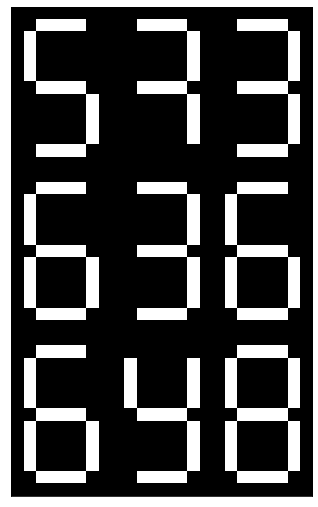

In [231]:
def generate_samples(n_samples, starting_point=(0, 0), starting_image=None):
    samples = torch.from_numpy(starting_image if starting_image is not None else np.zeros((n_samples*n_samples, 1, IMAGE_WIDTH, IMAGE_HEIGHT))).float()
    
    cnn.eval()
    with torch.no_grad():
        for i in range(IMAGE_WIDTH):
            for j in range(IMAGE_HEIGHT):
                if i < starting_point[0] or (i == starting_point[0] and j < starting_point[1]):
                    continue
                out = cnn(samples)
                probs = F.softmax(out[:, :, i, j]).data
                val = torch.multinomial(probs, 1).float()  
                samples[:, :, i, j] = val
                # print(val, end=', ')
        return samples.numpy()

generated = generate_samples(n_samples=3)
show_as_image(batch_images_to_one(generated ),figsize=(15,9))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


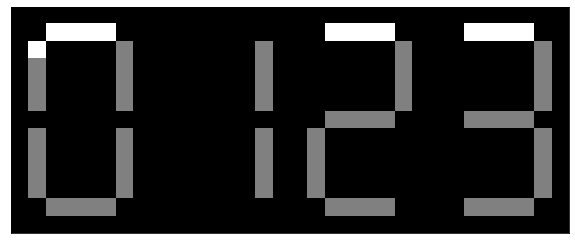

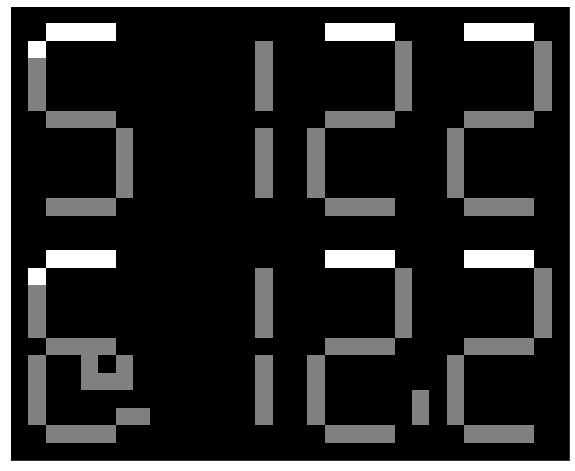

In [232]:
n_images = 2
starting_point = (2, 2)

mask = causal_mask(IMAGE_WIDTH, IMAGE_HEIGHT, starting_point)

starting_images = digits_list = [random_digits(fixed_label=d)[0] for d in range(4)]
batch_starting_images = np.expand_dims(np.stack([i * mask for i in starting_images] * n_images), axis=1)

samples = generate_samples(n_images, starting_image=batch_starting_images, starting_point=starting_point)

show_as_image(np.hstack([(1 + mask) * i for i in starting_images]), figsize=(10, 10))

show_as_image(
    batch_images_to_one((samples * (1 + mask))),
    figsize=(10, 20))